In [39]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset/amer_sign2.png
dataset/amer_sign3.png
dataset/sign_mnist_test.csv
dataset/american_sign_language.PNG
dataset/sign_mnist_train.csv
dataset/sign_mnist_train/sign_mnist_train.csv
dataset/sign_mnist_test/sign_mnist_test.csv


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

## Load the dataset

In [41]:
train_df = pd.read_csv('dataset/sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('dataset/sign_mnist_test/sign_mnist_test.csv')

In [42]:
test = pd.read_csv('dataset/sign_mnist_test/sign_mnist_test.csv')
y = test['label']

In [43]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


## Data Visualization and Preprocessing

<Axes: xlabel='label', ylabel='count'>

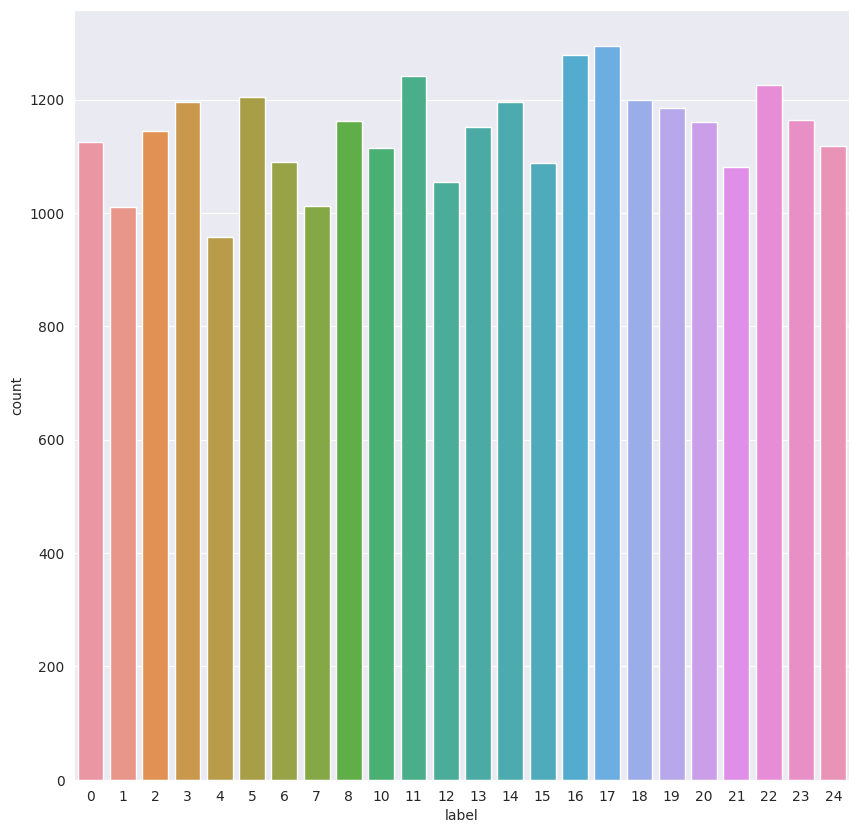

In [44]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(x = 'label', data = train_df)

In [45]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [46]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [47]:
x_train = train_df.values
x_test = test_df.values

Perform grayscale normalization to reduce the effect of illumination's differences. Moreover the CNN converges faster on [0..1] data than on [0..255].

In [48]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [49]:
# Reshaping the data from 1D to 3D as required through CNN
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1,28,28,1)

Display first 10 images

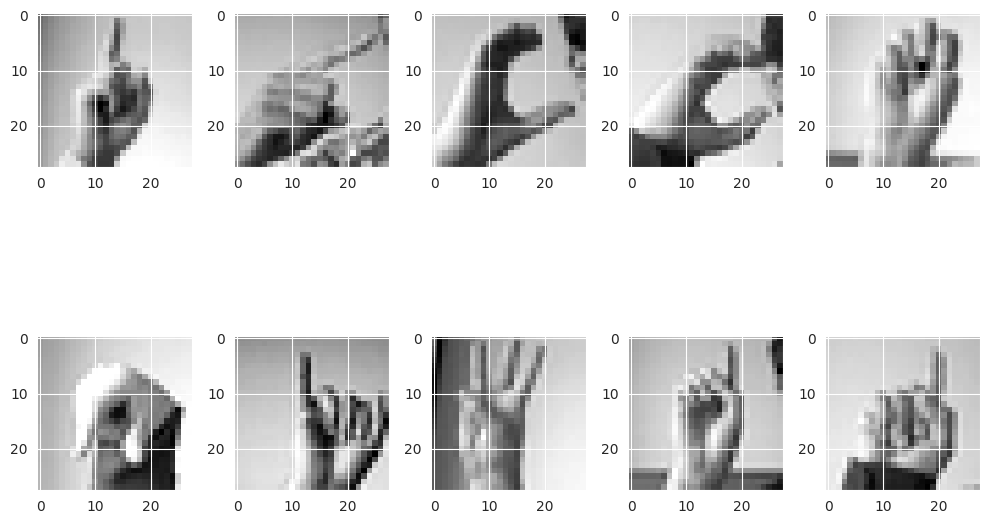

In [50]:
f, ax = plt.subplots(2, 5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(x_train[k].reshape(28, 28), cmap = 'gray')
        k += 1
    plt.tight_layout()

In [51]:
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False) # randomly flip images

datagen.fit(x_train)

## Training the model


In [52]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [53]:
model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=24, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 50)      

In [54]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=20, validation_data=(x_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/20


2023-07-27 18:00:31.081786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


215/215 [==============================] - 17s 76ms/step - loss: 1.1170 - accuracy: 0.6477 - val_loss: 3.6900 - val_accuracy: 0.0696 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 17s 80ms/step - loss: 0.2334 - accuracy: 0.9227 - val_loss: 1.2854 - val_accuracy: 0.5796 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 16s 75ms/step - loss: 0.1111 - accuracy: 0.9647 - val_loss: 0.2125 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 16s 75ms/step - loss: 0.0685 - accuracy: 0.9776 - val_loss: 0.3752 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 16s 75ms/step - loss: 0.0512 - accuracy: 0.9839 - val_loss: 0.0643 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 16s 74ms/step - loss: 0.0385 - accuracy: 0.9885 - val_loss: 0.0219 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 7/20
215/215 [==============================] - 16s 75ms/step -

In [55]:
print("Accuracy of the model is - ", model.evaluate(x_test,y_test)[1]*100,"%")

225/225 [==============================] - 1s 6ms/step - loss: 0.0291 - accuracy: 0.9912
Accuracy of the model is -  99.12158250808716 %


## Analysis after Model Training

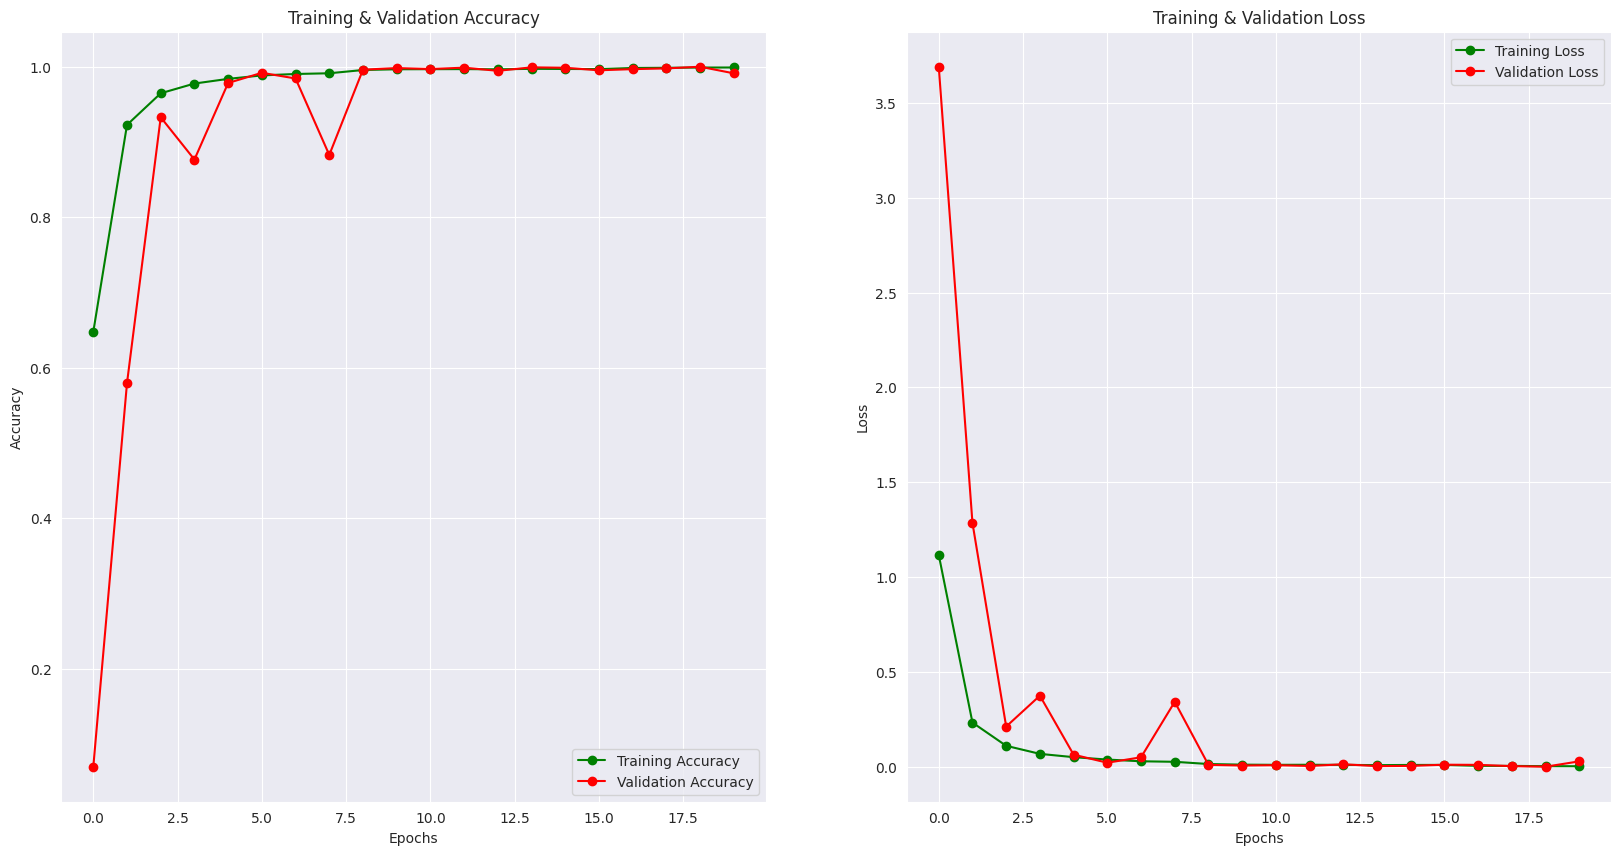

In [56]:
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()